In [1]:
# import things
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from tensorflow import reduce_sum, round, clip_by_value
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-01-17 20:13:57.545754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 20:13:57.545802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 20:13:57.547648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 20:13:57.557390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.
patch_size = 256
patch_dir = 'Y2B_24_23_filtered_2'

In [3]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
tf.keras.backend.clear_session()

In [5]:
# Define U-Net
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
   
    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    model.summary()
    
    return model

In [6]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
model = simple_unet_model(patch_size, patch_size, 1)

2025-01-17 20:14:09.241045: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-17 20:14:09.259066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24796 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

#### Set a function for generating and splitting the dataset

In [7]:
# Load all patches
def load_all_patches(dataset_type, patch_dir, target_size=(patch_size, patch_size)):
    # Load all patches
    images_dir = os.path.join(patch_dir, f"{dataset_type}_images", dataset_type)
    masks_dir = os.path.join(patch_dir, f"{dataset_type}_masks", dataset_type)
    # Load all images and masks
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))
    # define the arrays for X and y
    X = []
    y = []
    # for loop to iterate over all images and masks
    for img_file, mask_file in zip(image_files, mask_files):
        # read the image and mask
        img = cv2.imread(os.path.join(images_dir, img_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(masks_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        # check if the image or mask is None
        if img is None:
            print(f"Error: Image not found or failed to load: {images_dir}:{img}")
            continue
        if mask is None:
            print(f"Error: Mask not found or failed to load: {masks_dir}:{mask_file}")
            continue
        # resize the image and mask
        img = cv2.resize(img, target_size) / 255.0
        mask = cv2.resize(mask, target_size)
        # expand the dimensions of the image and mask
        mask = np.expand_dims(mask, axis=-1)
        # append the image and mask to the X and y arrays
        X.append(img)
        y.append(mask)
    # return the X and y arrays
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

#select the target size
target_size = (patch_size, patch_size)


In [8]:
# Setup a generator for training
X_train, y_train = load_all_patches(dataset_type='train', patch_dir=patch_dir, target_size=target_size)
X_train.shape, y_train.shape

((7922, 256, 256), (7922, 256, 256, 1))

In [9]:
# Setup a generator for validation
X_val, y_val = load_all_patches(dataset_type='val', patch_dir=patch_dir, target_size=target_size)
X_val.shape, y_val.shape

((815, 256, 256), (815, 256, 256, 1))

In [10]:
# EarlyStopping()
from keras.callbacks import EarlyStopping
cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [11]:
# This is where the magic happens
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 50, batch_size=16, callbacks=[cb])

Epoch 1/50


2025-01-17 20:15:33.697248: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-17 20:15:35.778351: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-01-17 20:15:39.828940: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0fcc118de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-17 20:15:39.828977: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-01-17 20:15:39.836989: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737144939.979837    7648 device_compiler.h:186] Compiled cluster using XLA!  This lin

496/496 [==============================] - 81s 108ms/step - loss: 0.0711 - accuracy: 0.9792 - f1: 0.4274 - val_loss: 0.0422 - val_accuracy: 0.9849 - val_f1: 0.7040
Epoch 2/50
496/496 [==============================] - 42s 85ms/step - loss: 0.0342 - accuracy: 0.9874 - f1: 0.7488 - val_loss: 0.0296 - val_accuracy: 0.9893 - val_f1: 0.7556
Epoch 3/50
496/496 [==============================] - 45s 91ms/step - loss: 0.0296 - accuracy: 0.9886 - f1: 0.7738 - val_loss: 0.0274 - val_accuracy: 0.9895 - val_f1: 0.7645
Epoch 4/50
496/496 [==============================] - 43s 86ms/step - loss: 0.0274 - accuracy: 0.9892 - f1: 0.7902 - val_loss: 0.0259 - val_accuracy: 0.9899 - val_f1: 0.7653
Epoch 5/50
496/496 [==============================] - 42s 84ms/step - loss: 0.0261 - accuracy: 0.9896 - f1: 0.7986 - val_loss: 0.0266 - val_accuracy: 0.9902 - val_f1: 0.7759
Epoch 6/50
496/496 [==============================] - 42s 84ms/step - loss: 0.0250 - accuracy: 0.9900 - f1: 0.8064 - val_loss: 0.0241 - val_

In [13]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'VladislavStoimenov_235030_unet_model_{patch_size}px5.h5'
print(example_file_name)
model.save(example_file_name)

VladislavStoimenov_235030_unet_model_256px5.h5


In [14]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.01761794276535511
Best validation f1: 0.8537212610244751


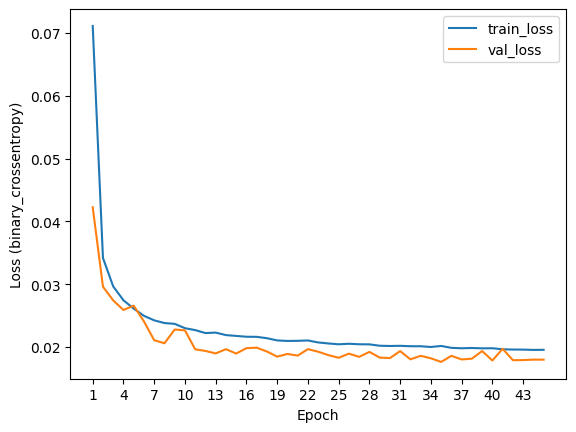

In [15]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

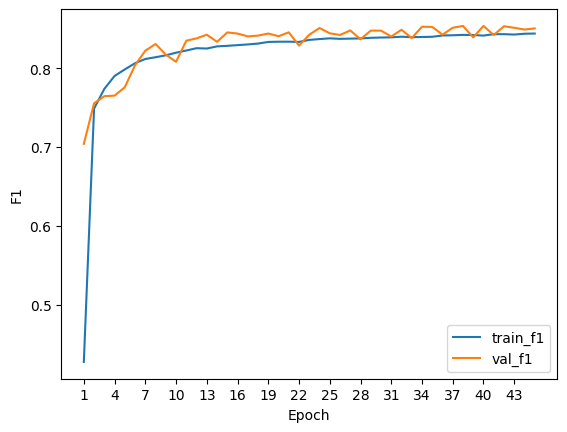

In [16]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))